### Importing Libraries

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import re
import folium

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [3]:
import re

#### NY data

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

#### Obtaining the Dataframe

In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [7]:
neighborhoods_data = newyork_data['features']

In [8]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [9]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [10]:
neighborhoods

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

In [11]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [12]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [13]:
neighborhoods.to_csv('NY.CSV')

In [14]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [15]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Creating Map

In [16]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [17]:
# The code was removed by Watson Studio for sharing.

In [18]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
         # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
NY_venues = getNearbyVenues(names = neighborhoods['Neighborhood'], latitudes = neighborhoods['Latitude'], longitudes = neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [20]:
print(NY_venues.shape)
NY_venues.head()

(10271, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                                     Venue  Venue Latitude  Venue Longitude  \
0                         Lollipops Gelato       40.894123       -73.845892   
1                                 Rite Aid       40.896649       -73.844846   
2                         Carvel Ice Cream       40.890487       -73.848568   
3                                    Shell       40.894187       -73.845862   
4  Cooler Runnings Jamaican Restaurant Inc       40.898083       -73.850259   

         Venue Category  
0          Dessert Shop  
1              Pharmacy  
2        Ice Cream Shop  
3           Gas Station  
4  Caribbean Restaurant

In [21]:
NY_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Allerton                                      31                      31   
Annadale                                      13                      13   
Arden Heights                                  6                       6   
Arlington                                      7                       7   
Arrochar                                      22                      22   
Arverne                                       18                      18   
Astoria                                      100                     100   
Astoria Heights                               15                      15   
Auburndale                                    19                      19   
Bath Beach                                    51                      51   
Battery Park City                             97                      97   
Bay Ridge                                     84                      84   
Bay Terrace                                   47                      47   
Baychester                                    21                      21   
Bayside                                       76                      76   
Bayswater                                      2                       2   
Bedford Park                                  30                      30   
Bedford Stuyvesant                            25                      25   
Beechhurst                                    15                      15   
Bellaire                                      12                      12   
Belle Harbor                                  17                      17   
Bellerose                                     22                      22   
Belmont                                       97                      97   
Bensonhurst                                   33                      33   
Bergen Beach                                   6                       6   
Blissville                                    16                      16   
Bloomfield                                     5                       5   
Boerum Hill                                   92                      92   
Borough Park                                  22                      22   
Breezy Point                                   3                       3   
Briarwood                                      8                       8   
Brighton Beach                                45                      45   
Broad Channel                                  5                       5   
Broadway Junction                             16                      16   
Bronxdale                                     15                      15   
Brooklyn Heights                             100                     100   
Brookville                                     2                       2   
Brownsville                                   16                      16   
Bulls Head                                    43                      43   
Bushwick                                      77                      77   
Butler Manor                                   6                       6   
Cambria Heights                               13                      13   
Canarsie                                       7                       7   
Carnegie Hill                                100                     100   
Carroll Gardens                              100                     100   
Castle Hill                                    9                       9   
Castleton Corners                             15                      15   
Central Harlem                                43                      43   
Charleston                                    31                      31   
Chelsea                                      106                     106   
Chinatown                                    100                     100   

In [22]:
print('There are {} unique categories.'.format(len(NY_venues['Venue Category'].unique())))

There are 424 unique categories.


In [23]:
# one hot encoding
NY_onehot = pd.get_dummies(NY_venues[['Venue Category']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
NY_onehot['Neighborhood'] = NY_venues['Neighborhood']

# move neighborhood column to the first column
col_list = list(NY_onehot.columns)
col_list.remove('Neighborhood')
cols = ['Neighborhood'] + [col for col in col_list]

NY_onehot = NY_onehot[cols]

NY_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0    Wakefield                  0               0                  0   
1    Wakefield                  0               0                  0   
2    Wakefield                  0               0                  0   
3    Wakefield                  0               0                  0   
4    Wakefield                  0               0                  0   

   African Restaurant  American Restaurant  Antique Shop  Arcade  \
0                   0                    0             0       0   
1                   0                    0             0       0   
2                   0                    0             0       0   
3                   0                    0             0       0   
4                   0                    0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   
3                   0           0                      0                    0   
4                   0           0                      0                    0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0                0          0           0           0       0     0    0   
1                0          0           0           0       0     0    0   
2                0          0           0           0       0     0    0   
3                0          0           0           0       0     0    0   
4                0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Bath House  Beach  \
0               0                 0                 0           0      0   
1               0                 0                 0           0      0   
2               0                 0                 0           0      0   
3               0                 0                 0           0      0   
4               0                 0                 0           0      0   

   Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0          0                0         0            0           0   
1          0                0         0            0           0   
2          0                0         0            0           0   
3          0                0         0            0           0   
4          0                0         0            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0              0                         0          0           0       0   
1              0                         0          0           0       0   
2              0                         0          0           0       0   
3              0                         0          0           0       0   
4              0                         0          0           0       0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Bowlin

In [24]:
NY_onehot.shape

(10271, 424)

In [28]:
NY_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()
NY_grouped

Neighborhood  Accessories Store  Adult Boutique  \
0                     Allerton           0.000000            0.00   
1                     Annadale           0.000000            0.00   
2                Arden Heights           0.000000            0.00   
3                    Arlington           0.000000            0.00   
4                     Arrochar           0.000000            0.00   
5                      Arverne           0.000000            0.00   
6                      Astoria           0.000000            0.00   
7              Astoria Heights           0.000000            0.00   
8                   Auburndale           0.000000            0.00   
9                   Bath Beach           0.000000            0.00   
10           Battery Park City           0.000000            0.00   
11                   Bay Ridge           0.000000            0.00   
12                 Bay Terrace           0.021277            0.00   
13                  Baychester           0.000000            0.00   
14                     Bayside           0.000000            0.00   
15                   Bayswater           0.000000            0.00   
16                Bedford Park           0.000000            0.00   
17          Bedford Stuyvesant           0.000000            0.00   
18                  Beechhurst           0.000000            0.00   
19                    Bellaire           0.000000            0.00   
20                Belle Harbor           0.000000            0.00   
21                   Bellerose           0.000000            0.00   
22                     Belmont           0.000000            0.00   
23                 Bensonhurst           0.000000            0.00   
24                Bergen Beach           0.000000            0.00   
25                  Blissville           0.000000            0.00   
26                  Bloomfield           0.000000            0.00   
27                 Boerum Hill           0.000000            0.00   
28                Borough Park           0.000000            0.00   
29                Breezy Point           0.000000            0.00   
30                   Briarwood           0.000000            0.00   
31              Brighton Beach           0.000000            0.00   
32               Broad Channel           0.000000            0.00   
33           Broadway Junction           0.000000            0.00   
34                   Bronxdale           0.000000            0.00   
35            Brooklyn Heights           0.000000            0.00   
36                  Brookville           0.000000            0.00   
37                 Brownsville           0.000000            0.00   
38                  Bulls Head           0.000000            0.00   
39                    Bushwick           0.000000            0.00   
40                Butler Manor           0.000000            0.00   
41             Cambria Heights           0.000000            0.00   
42                    Canarsie           0.000000            0.00   
43               Carnegie Hill           0.000000            0.00   
44             Carroll Gardens           0.000000            0.00   
45                 Castle Hill           0.000000            0.00   
46           Castleton Corners           0.000000            0.00   
47              Central Harlem           0.000000            0.00   
48                  Charleston           0.000000            0.00   
49                     Chelsea           0.000000            0.00   
50                   Chinatown           0.000000            0.00   
51                 City Island           0.000000            0.00   
52                   City Line           0.000000            0.00   
53                Civic Center           0.000000            0.00   
54           Claremont Village           0.000000            0.00   
55                Clason Point           0.000000            0.00   
56                     Clifton           0.000000            0.00   
57              

In [29]:
NY_grouped.shape

(302, 424)

In [30]:
NY_grouped.to_csv('NY-G.csv')

##### Toronto data

#### Libraries

In [28]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import requests
import re

import json 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup

import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [33]:
from bs4 import BeautifulSoup

In [31]:
wiki_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

##### Obtaining the Dataframe

In [34]:
req = requests.get(wiki_url)
soup = BeautifulSoup(req.content, 'lxml')
table_classes = {"class": ["sortable", "plainrowheaders"]}
wikitables = soup.findAll("table", table_classes)
wikitables

[<table class="wikitable sortable">
 <tbody><tr>
 <th>Postcode</th>
 <th>Borough</th>
 <th>Neighbourhood
 </th></tr>
 <tr>
 <td>M1A</td>
 <td>Not assigned</td>
 <td>Not assigned
 </td></tr>
 <tr>
 <td>M2A</td>
 <td>Not assigned</td>
 <td>Not assigned
 </td></tr>
 <tr>
 <td>M3A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
 </td></tr>
 <tr>
 <td>M4A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
 </td></tr>
 <tr>
 <td>M5A</td>
 <td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
 <td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
 </td></tr>
 <tr>
 <td>M6A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
 </td></tr>
 <tr>


In [35]:
for table in wikitables:
    ths = table.find_all('th')
    headings = [th.text.strip() for th in ths]
    if headings[:3] == ['Postcode', 'Borough', "Neighborhood"]:
        break
with open('list_of_postal_codes_of_canada.txt', 'w') as fo:
    for tr in table.find_all('tr'):
        tds = tr.find_all('td')
        if not tds:
            continue
        PostalCode, Borough, Neighborhood = [td.text.strip() for td in tds[:3]]
        
        print('; '.join([PostalCode, Borough, Neighborhood]), file=fo)

In [36]:
df = pd.read_csv('list_of_postal_codes_of_canada.txt', sep = ';', header = None, names = ['PostalCode', 'Borough', 'Neighborhood'])
df.head()

PostalCode            Borough       Neighborhood
0        M1A       Not assigned       Not assigned
1        M2A       Not assigned       Not assigned
2        M3A         North York          Parkwoods
3        M4A         North York   Victoria Village
4        M5A   Downtown Toronto       Harbourfront

In [37]:
booleans = []

for result in df.Borough:
    if not re.search('Not assigned', result):
        booleans.append(True)
    else:
        booleans.append(False)
print(booleans[0:5])
print(len(booleans))

Filtered = pd.Series(booleans)

can_data = df[Filtered].reset_index(drop = True)

can_data.head(5)

[False, False, True, True, True]
287


PostalCode            Borough       Neighborhood
0        M3A         North York          Parkwoods
1        M4A         North York   Victoria Village
2        M5A   Downtown Toronto       Harbourfront
3        M6A         North York   Lawrence Heights
4        M6A         North York     Lawrence Manor

In [38]:
new_cd = can_data.astype(str).groupby('PostalCode')['Neighborhood'].agg(','.join).reset_index()
merged_cd = pd.merge(can_data, new_cd, on = ['PostalCode'], how = 'inner')
duplicate_cd = merged_cd.drop(['Neighborhood_x'], axis = 1)
final_cd = duplicate_cd.drop_duplicates(subset='PostalCode')
final_cd.columns = ['PostalCode', 'Borough', 'Neighborhood']
final_cd = final_cd.reset_index(drop = True)

In [39]:
boolean = []

for result in final_cd.Neighborhood:
    if not re.search('Not assigned', result):
        boolean.append(True)
    else:
        boolean.append(False)



Filter = pd.Series(boolean)

X = final_cd['Neighborhood'].where(boolean, np.nan)
X = pd.Series(X)
final_cd = final_cd.drop(['Neighborhood'], axis = 1)

final_cd['Neighborhood'] = X.values

In [40]:
final_cd["Neighborhood"] = final_cd["Neighborhood"].fillna(final_cd["Borough"])
final_cd.head()


PostalCode            Borough                       Neighborhood
0        M3A         North York                          Parkwoods
1        M4A         North York                   Victoria Village
2        M5A   Downtown Toronto                       Harbourfront
3        M6A         North York   Lawrence Heights, Lawrence Manor
4        M7A   Downtown Toronto                       Queen's Park

In [41]:
final_cd.shape

(103, 3)

In [42]:
path = "http://cocl.us/Geospatial_data"

ll_df = pd.read_csv(path)
ll_df.columns = ['PostalCode', 'Latitude', 'Longitude']
ll_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [43]:
toronto_data = pd.merge(final_cd, ll_df, on = ['PostalCode'], how = 'inner')
toronto_data.head()

PostalCode            Borough                       Neighborhood   Latitude  \
0        M3A         North York                          Parkwoods  43.753259   
1        M4A         North York                   Victoria Village  43.725882   
2        M5A   Downtown Toronto                       Harbourfront  43.654260   
3        M6A         North York   Lawrence Heights, Lawrence Manor  43.718518   
4        M7A   Downtown Toronto                       Queen's Park  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [44]:
toronto_data.to_csv('Toronto.csv')

In [45]:
address = 'Toronto, Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 43.653963, -79.387207.


#### Creating Map

In [46]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [47]:
# The code was removed by Watson Studio for sharing.

In [48]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
         # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [49]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

 Parkwoods
 Victoria Village
 Harbourfront
 Lawrence Heights, Lawrence Manor
 Queen's Park
 Queen's Park
 Rouge, Malvern
 Don Mills North
 Woodbine Gardens, Parkview Hill
 Ryerson, Garden District
 Glencairn
 Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
 Highland Creek, Rouge Hill, Port Union
 Flemingdon Park, Don Mills South
 Woodbine Heights
 St. James Town
 Humewood-Cedarvale
 Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
 Guildwood, Morningside, West Hill
 The Beaches
 Berczy Park
 Caledonia-Fairbanks
 Woburn
 Leaside
 Central Bay Street
 Christie
 Cedarbrae
 Hillcrest Village
 Bathurst Manor, Downsview North, Wilson Heights
 Thorncliffe Park
 Adelaide, King, Richmond
 Dovercourt Village, Dufferin
 Scarborough Village
 Fairview, Henry Farm, Oriole
 Northwood Park, York University
 East Toronto
 Harbourfront East, Toronto Islands, Union Station
 Little Portugal, Trinity
 East Birchmount Park, Ionview, Kennedy Park
 Bayview Village
 CFB Toron

In [50]:
print(toronto_venues.shape)
toronto_venues.head()

(2220, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0          Parkwoods              43.753259              -79.329656   
1          Parkwoods              43.753259              -79.329656   
2   Victoria Village              43.725882              -79.315572   
3   Victoria Village              43.725882              -79.315572   
4   Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1           Variety Store       43.751974       -79.333114   
2  Victoria Village Arena       43.723481       -79.315635   
3             Tim Hortons       43.725517       -79.313103   
4               Portugril       43.725819       -79.312785   

          Venue Category  
0                   Park  
1      Food & Drink Shop  
2           Hockey Arena  
3            Coffee Shop  
4  Portuguese Restaurant

In [51]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
 Adelaide, King, Richmond                                             100   
 Agincourt                                                              5   
 Agincourt North, L'Amoreaux East, Milliken, St...                      2   
 Albion Gardens, Beaumond Heights, Humbergate, ...                      9   
 Alderwood, Long Branch                                                 8   
 Bathurst Manor, Downsview North, Wilson Heights                       21   
 Bayview Village                                                        4   
 Bedford Park, Lawrence Manor East                                     24   
 Berczy Park                                                           55   
 Birch Cliff, Cliffside West                                            4   
 Bloordale Gardens, Eringate, Markland Wood, Ol...                      7   
 Brockton, Exhibition Place, Parkdale Village                          25   
 Business Reply Mail Processing Centre 969 Eastern                     18   
 CFB Toronto, Downsview East                                            4   
 CN Tower, Bathurst Quay, Island airport, Harbo...                     15   
 Cabbagetown, St. James Town                                           48   
 Caledonia-Fairbanks                                                    4   
 Canada Post Gateway Processing Centre                                 12   
 Cedarbrae                                                              8   
 Central Bay Street                                                    83   
 Chinatown, Grange Park, Kensington Market                             88   
 Christie                                                              18   
 Church and Wellesley                                                  81   
 Clairlea, Golden Mile, Oakridge                                       10   
 Clarks Corners, Sullivan, Tam O'Shanter                               11   
 Cliffcrest, Cliffside, Scarborough Village West                        2   
 Commerce Court, Victoria Hotel                                       100   
 Davisville                                                            34   
 Davisville North                                                       8   
 Deer Park, Forest Hill SE, Rathnelly, South Hi...                     14   
 Del Ray, Keelesdale, Mount Dennis, Silverthorn                         4   
 Design Exchange, Toronto Dominion Centre                             100   
 Don Mills North                                                        4   
 Dorset Park, Scarborough Town Centre, Wexford ...                      7   
 Dovercourt Village, Dufferin                                          17   
 Downsview Central                                                      3   
 Downsview Northwest                                                    5   
 Downsview West                                                         5   
 Downsview, North Park, Upwood Park                                     4   
 East Birchmount Park, Ionview, Kennedy Park                            6   
 East Toronto                                                           5   
 Emery, Humberlea                                                       2   
 Fairview, Henry Farm, Oriole                                          61   
 First Canadian Place, Underground city                               100   
 Flemingdon Park, Don Mills South                                      23   
 Forest Hill North, Forest Hill West                                    4   
 Glencairn                                                              5   
 Guildwood, Morningside, West Hill                                      8   
 Harbord, University of Toronto                                        35   
 Harbourfront                                                          47   
 Harbourfront East, Toronto Islands, Union Stati

In [52]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 268 uniques categories.


In [53]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
col_list = list(toronto_onehot.columns)
col_list.remove('Neighborhood')
cols = ['Neighborhood'] + [col for col in col_list]

toronto_onehot = toronto_onehot[cols]
toronto_onehot.head()

Neighborhood  Accessories Store  Afghan Restaurant  Airport  \
0          Parkwoods                  0                  0        0   
1          Parkwoods                  0                  0        0   
2   Victoria Village                  0                  0        0   
3   Victoria Village                  0                  0        0   
4   Victoria Village                  0                  0        0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                    0             0         0            0   
1                    0             0         0            0   
2                    0             0         0            0   
3                    0             0         0            0   
4                    0             0         0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0      0                0         0           0                   0   
1      0                0         0           0                   0   
2      0                0         0           0                   0   
3      0                0         0           0                   0   
4      0                0         0           0                   0   

   Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0          0       0              0          0         0   
1          0       0              0          0         0   
2          0       0              0          0         0   
3          0       0              0          0         0   
4          0       0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0                0         0             0              0         0   
1                0         0             0           

In [54]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  Accessories Store  \
0                           Adelaide, King, Richmond                0.0   
1                                          Agincourt                0.0   
2   Agincourt North, L'Amoreaux East, Milliken, S...                0.0   
3   Albion Gardens, Beaumond Heights, Humbergate,...                0.0   
4                             Alderwood, Long Branch                0.0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Lounge  \
0                0.0      0.0                 0.0             0.0   
1                0.0      0.0                 0.0             0.0   
2                0.0      0.0                 0.0             0.0   
3                0.0      0.0                 0.0             0.0   
4                0.0      0.0                 0.0             0.0   

   Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
0              0.0               0.0                 0.02           0.0   
1              0.0               0.0                 0.00           0.0   
2              0.0               0.0                 0.00           0.0   
3              0.0               0.0                 0.00           0.0   
4              0.0               0.0                 0.00           0.0   

   Aquarium  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0       0.0          0.0                  0.0              0.02   
1       0.0          0.0                  0.0              0.00   
2       0.0          0.0                  0.0              0.00   
3       0.0          0.0                  0.0              0.00   
4       0.0          0.0                  0.0              0.00   

   Athletics & Sports  Auto Garage  Auto Workshop  BBQ Joint  Baby Store  \
0                 0.0          0.0            0.0        0.0         0.0   
1                 0.0          0.0            0.0        0.0         0.0   
2                 0.0          0.0            0.0        0.0         0.0   
3                 0.0          0.0            0.0        0.0         0.0   
4                 0.0          0.0            0.0        0.0         0.0   

   Bagel Shop  Bakery  Bank   Bar  Baseball Field  Baseball Stadium  \
0         0.0    0.03   0.0  0.04             0.0               0.0   
1         0.0    0.00   0.0  0.00             0.0               0.0   
2         0.0    0.00   0.0  0.00             0.0               0.0   
3         0.0    0.00   0.0  0.00             0.0               0.0   
4         0.0    0.00   0.0  0.00             0.0               0.0   

   Basketball Court  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0       0.0   
1               0.0                 0.0    0.0              0.0       0.0   
2               0.0                 0.0    0.0              0.0       0.0   
3               0.0                 0.0    0.0              0.0       0.0   
4               0.0                 0.0    0.0              0.0       0.0   

   Beer Store  Belgian Restaurant  Bike Shop  Bistro  Boat or Ferry  \
0    0.000000                 0.0        0.0     0.0            0.0   
1    0.000000                 0.0        0.0     0.0            0.0   
2    0.000000                 0.0        0.0     0.0            0.0   
3    0.111111                 0.0        0.0     0.0            0.0   
4    0.000000                 0.0        0.0     0.0            0.0   

   Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  \
0       0.01       0.0                  0.01            0.02      0.0   
1       0.00       0.0                  0.00            0.20      0.0   
2       0.00       0.0                  0.00            0.00      0.0   
3       0.00       0.0                  0.00            0.00      0.0   
4       0.00       0.0                  0.00            0.00      0.0   

   Bridal Shop  Bubble Tea Shop  Building  Burger Joint  Burrito Place  \
0          0.0              0.0  

In [55]:
toronto_grouped.shape

(100, 268)

In [56]:
toronto_grouped.to_csv('Toronto-G.csv')

### NY vs. Toronto

##### Importing Libraries 

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

!conda install -c conda-forge folium=0.5.0 --yes
import folium



Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

##### Importing DF from the Notebook

In [73]:
NY_grouped = pd.read_csv('NY-G.csv')
toronto_grouped= pd.read_csv ('Toronto-G.csv')

##### Merging New York and Toronto data in order to perform clustering

In [74]:
L1 = list(NY_grouped.columns)
L2 = list(toronto_grouped.columns)
L=list(set(L1).intersection(L2))

df=pd.merge(NY_grouped,toronto_grouped, on=L,how='outer')
cols = [col for col in df.columns if col not in L]
df=df.drop(cols,axis=1)
df.head()

Unnamed: 0   Neighborhood  Accessories Store  Afghan Restaurant  \
0           0       Allerton                0.0                0.0   
1           1       Annadale                0.0                0.0   
2           2  Arden Heights                0.0                0.0   
3           3      Arlington                0.0                0.0   
4           4       Arrochar                0.0                0.0   

   American Restaurant  Antique Shop  Art Gallery  Arts & Crafts Store  \
0             0.000000           0.0          0.0                  0.0   
1             0.076923           0.0          0.0                  0.0   
2             0.000000           0.0          0.0                  0.0   
3             0.142857           0.0          0.0                  0.0   
4             0.000000           0.0          0.0                  0.0   

   Asian Restaurant  Athletics & Sports  BBQ Joint  Baby Store  Bagel Shop  \
0               0.0            0.000000        0.0         0.0    0.000000   
1               0.0            0.000000        0.0         0.0    0.000000   
2               0.0            0.000000        0.0         0.0    0.000000   
3               0.0            0.000000        0.0         0.0    0.000000   
4               0.0            0.045455        0.0         0.0    0.045455   

     Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0  0.032258   0.0  0.0             0.0               0.0               0.0   
1  0.000000   0.0  0.0             0.0               0.0               0.0   
2  0.000000   0.0  0.0             0.0               0.0               0.0   
3  0.000000   0.0  0.0             0.0               0.0               0.0   
4  0.000000   0.0  0.0             0.0               0.0               0.0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Bike Shop  Bistro  \
0    0.0              0.0       0.0         0.0        0.0     0.0   
1    0.0              0.0       0.0         0.0        0.0     0.0   
2    0.0              0.0       0.0         0.0        0.0     0.0   
3    0.0              0.0       0.0         0.0        0.0     0.0   
4    0.0              0.0       0.0         0.0        0.0     0.0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0       0.000000        0.0       0.0                   0.0        0.032258   
1       0.000000        0.0       0.0                   0.0        0.000000   
2       0.000000        0.0       0.0                   0.0        0.000000   
3       0.142857        0.0       0.0                   0.0        0.000000   
4       0.000000        0.0       0.0                   0.0        0.000000   

   Brewery  Bridal Shop  Bubble Tea Shop  Building  Burger Joint  \
0      0.0          0.0              0.0       0.0           0.0   
1      0.0          0.0              0.0       0.0           0.0   
2      0.0          0.0              0.0       0.0           0.0   
3      0.0          0.0              0.0       0.0           0.0   
4      0.0          0.0              0.0       0.0           0.0   

   Burrito Place  Bus Line  Bus Station  Butcher  Cafeteria  Café  \
0            0.0       0.0     0.064516      0.0        0.0   0.0   
1            0.0       0.0     0.000000      0.0        0.0   0.0   
2            0.0       0.0     0.000000      0.0        0.0   0.0   
3            0.0       0.0     0.000000      0.0        0.0   0.0   
4            0.0       0.0     0.000000      0.0        0.0   0.0   

   Cajun / Creole Restaurant  Camera Store  Candy Store  Caribbean Restaurant  \
0                        0.0           0.0          0.0                   0.0   
1                        0.0           0.0          0.0                   0.0   
2                        0.0           0.0          0.0                   0.0   
3                        0.0           0.0          0.0                   0.0   
4                        0.0           0.0          0.0                   

#### Implementing PCA in order to reduce dimensionality, yet retaining the variance

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Text(0, 0.5, 'cumulative explained variance')

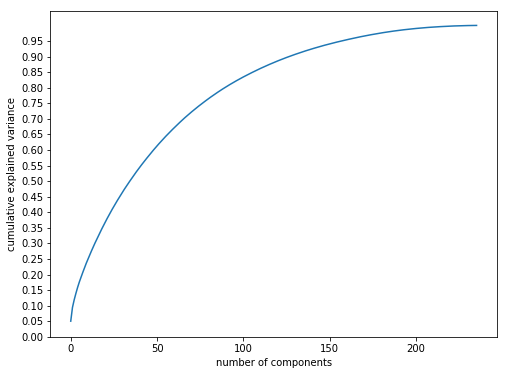

In [75]:

neigh_name = df['Neighborhood']
df_grouped_clustering = df.drop('Neighborhood', 1)

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(df_grouped_clustering)

pca = PCA().fit(data_rescaled)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.arange(0, 1.0, step=0.05))
# plt.xticks(np.arange(0, 450, step=30))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [76]:
pca = PCA(n_components=125)
dataset = pca.fit_transform(data_rescaled)

#### Elbow Method to determine the number of clusters

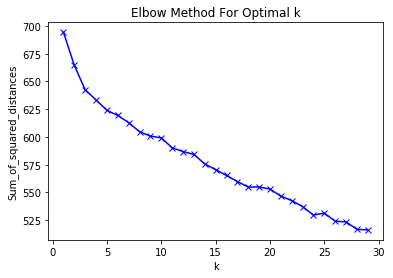

In [77]:
Sum_of_squared_distances = []
K = range(1, 30)
for kclusters in K:
    km = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(dataset)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Silhouette score method to determine the number of clusters

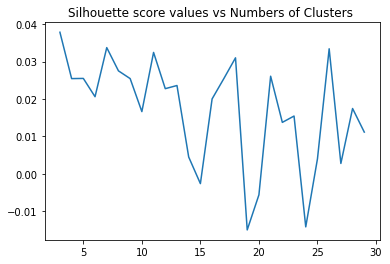

Optimal number of components is:
3


In [78]:
obs = dataset.copy() 
# obs = numpy.concatenate( (numpy.random.randn(100, 2) , 20 + numpy.random.randn(300, 2) , -15+numpy.random.randn(200, 2)))
silhouette_score_values=list()
 
NumberOfClusters=range(3,30)
 
for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=10)
    classifier.fit(obs)
    labels= classifier.predict(obs)
#     print("Number Of Clusters:")
#     print(i)
#     print("Silhouette score value")
#     print(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', random_state=0))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)


### Function to return top 3 venues

In [79]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues =3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df['Neighborhood']

for ind in np.arange(df.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

In [81]:
df_grouped_clustering = dataset.copy()
df_grouped_clustering

array([[ 1.44922565e-01, -4.90929655e-01,  1.70802319e-01, ...,
         2.73986220e-02,  1.82193919e-02,  1.22385574e-02],
       [ 2.18877147e-01, -4.22052598e-01,  1.16853392e-01, ...,
         9.90343167e-03,  1.11291419e-02, -1.41233137e-02],
       [ 1.82594185e-01, -4.67974802e-01,  1.72465561e-01, ...,
         3.19411292e-02,  1.90613825e-02,  4.67103082e-02],
       ...,
       [ 2.38526637e-02, -2.57772938e-01,  1.12743764e-02, ...,
        -4.10500161e-04, -4.38521194e-02, -6.23504801e-02],
       [-1.40943589e-02, -2.99733398e-01,  1.99027585e-02, ...,
        -9.84898092e-02, -2.27677089e-01, -2.34859103e-02],
       [-1.96281420e-02, -2.06406986e-01, -1.72933346e-01, ...,
        -4.71724381e-02,  2.63901287e-02,  6.34671679e-02]])

#### Performing K-Means

In [82]:
# set number of clusters
kclusters = 5


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=2, copy_x=True).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [83]:
df_grouped_with_cluster = df.copy()
df_grouped_with_cluster.insert(0, 'Cluster_Labels', kmeans.labels_)

In [84]:
df_grouped_with_cluster.head()

Cluster_Labels  Unnamed: 0   Neighborhood  Accessories Store  \
0               1           0       Allerton                0.0   
1               1           1       Annadale                0.0   
2               1           2  Arden Heights                0.0   
3               1           3      Arlington                0.0   
4               1           4       Arrochar                0.0   

   Afghan Restaurant  American Restaurant  Antique Shop  Art Gallery  \
0                0.0             0.000000           0.0          0.0   
1                0.0             0.076923           0.0          0.0   
2                0.0             0.000000           0.0          0.0   
3                0.0             0.142857           0.0          0.0   
4                0.0             0.000000           0.0          0.0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  BBQ Joint  \
0                  0.0               0.0            0.000000        0.0   
1                  0.0               0.0            0.000000        0.0   
2                  0.0               0.0            0.000000        0.0   
3                  0.0               0.0            0.000000        0.0   
4                  0.0               0.0            0.045455        0.0   

   Baby Store  Bagel Shop    Bakery  Bank  Bar  Baseball Field  \
0         0.0    0.000000  0.032258   0.0  0.0             0.0   
1         0.0    0.000000  0.000000   0.0  0.0             0.0   
2         0.0    0.000000  0.000000   0.0  0.0             0.0   
3         0.0    0.000000  0.000000   0.0  0.0             0.0   
4         0.0    0.045455  0.000000   0.0  0.0             0.0   

   Baseball Stadium  Basketball Court  Beach  Bed & Breakfast  Beer Bar  \
0               0.0               0.0    0.0              0.0       0.0   
1               0.0               0.0    0.0              0.0       0.0   
2               0.0               0.0    0.0              0.0       0.0   
3               0.0               0.0    0.0              0.0       0.0   
4               0.0               0.0    0.0              0.0       0.0   

   Beer Store  Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0         0.0        0.0     0.0       0.000000        0.0       0.0   
1         0.0        0.0     0.0       0.000000        0.0       0.0   
2         0.0        0.0     0.0       0.000000        0.0       0.0   
3         0.0        0.0     0.0       0.142857        0.0       0.0   
4         0.0        0.0     0.0       0.000000        0.0       0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                   0.0        0.032258      0.0          0.0   
1                   0.0        0.000000      0.0          0.0   
2                   0.0        0.000000      0.0          0.0   
3                   0.0        0.000000      0.0          0.0   
4                   0.0        0.000000      0.0          0.0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0              0.0       0.0           0.0            0.0       0.0   
1              0.0       0.0           0.0            0.0       0.0   
2              0.0       0.0           0.0            0.0       0.0   
3              0.0       0.0           0.0            0.0       0.0   
4              0.0       0.0           0.0            0.0       0.0   

   Bus Station  Butcher  Cafeteria  Café  Cajun / Creole Restaurant  \
0     0.064516      0.0        0.0   0.0                        0.0   
1     0.000000      0.0        0.0   0.0                        0.0   
2     0.000000      0.0        0.0   0.0                        0.0   
3     0.000000      0.0        0.0   0.0                        0.0   
4     0.000000      0.0        0.0   0.0                        0.0   

   Camera Store  Candy Store  Caribbean Restaurant  Cheese Shop  \
0           0.0          0.0                   0.0          0.0   
1           0.0          0.0                   0.0      

In [85]:
df_with_cluster_and_neighborhood = df_grouped_with_cluster[['Cluster_Labels', 'Neighborhood']]

In [86]:
df_with_cluster_and_neighborhood.to_csv('DF_cluster_neighborhood')

### Appending New York data and Toronto data with respective cluster labels

In [88]:
NY_data = pd.read_csv('NY.CSV')
Toronto_data = pd.read_csv('Toronto.csv')
print('NY_data shape: ', NY_data.shape)
print('Toronto_data shape: ', Toronto_data.shape)

NY_data shape:  (306, 5)
Toronto_data shape:  (103, 6)


In [89]:
NY_data_merged = NY_data[['Neighborhood', 'Latitude', 'Longitude']]
NY_data_merged = NY_data_merged.merge(df_with_cluster_and_neighborhood, on = 'Neighborhood', how = 'left')

In [90]:
NY_data_merged.dropna(inplace = True)
NY_data_merged.head()

Neighborhood   Latitude  Longitude  Cluster_Labels
0    Wakefield  40.894705 -73.847201               4
1   Co-op City  40.874294 -73.829939               1
2  Eastchester  40.887556 -73.827806               4
3    Fieldston  40.895437 -73.905643               1
4    Riverdale  40.890834 -73.912585               3

In [93]:
NY_data_merged.shape

(306, 4)

In [91]:
Toronto_data_merged = Toronto_data[['Neighborhood', 'Latitude', 'Longitude']]
Toronto_data_merged = Toronto_data_merged.merge(df_with_cluster_and_neighborhood, on = 'Neighborhood', how = 'left')

In [95]:
Toronto_data_merged.head()

Neighborhood   Latitude  Longitude  Cluster_Labels
0                          Parkwoods  43.753259 -79.329656             1.0
1                   Victoria Village  43.725882 -79.315572             1.0
2                       Harbourfront  43.654260 -79.360636             2.0
3   Lawrence Heights, Lawrence Manor  43.718518 -79.464763             1.0
4                       Queen's Park  43.662301 -79.389494             2.0

In [92]:
Toronto_data_merged.dropna(inplace = True)
Toronto_data_merged.shape

(101, 4)

#### Visualizing New York City clusters in Folium Map

In [97]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="NY_explorer")
location = geolocator.geocode(address)
latitude_NY = location.latitude
longitude_NY = location.longitude
print('The geograpical coordinate of Detroit,MI are {}, {}.'.format(latitude_NY, longitude_NY))

The geograpical coordinate of Detroit,MI are 40.7896239, -73.9598939.


In [98]:
# create map
map_NY_with_clusters = folium.Map(location=[latitude_NY, longitude_NY], zoom_start= 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_data_merged['Latitude'], NY_data_merged['Longitude'], NY_data_merged['Neighborhood'], NY_data_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + " "  + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_NY_with_clusters)
       
map_NY_with_clusters

#### Visualizing Toronto City Clusters with Folium Map

In [99]:
address_can = 'East York, Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address_can)
latitude_tor = location.latitude
longitude_tor = location.longitude
print('The geograpical coordinate of Detroit,MI are {}, {}.'.format(latitude_tor, longitude_tor))

The geograpical coordinate of Detroit,MI are 43.699971000000005, -79.33251996261595.


In [100]:
# create map
map_Toronto_with_clusters = folium.Map(location=[latitude_tor, longitude_tor], zoom_start= 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_data_merged['Latitude'], Toronto_data_merged['Longitude'], Toronto_data_merged['Neighborhood'], Toronto_data_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + " "  + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_Toronto_with_clusters)
       
map_Toronto_with_clusters